In [1]:
from runlmc.models.lmc import LMC, interp_cubic
from runlmc.kern.rbf import RBF
from paramz.optimization import Optimizer
import numpy as np
import math
import numpy as np
import scipy
import scipy.sparse 
from scipy.spatial.distance import cdist

%matplotlib inline  
import matplotlib.pyplot as plt

np.random.seed(1234)


In [2]:
n_per_output = [100]
ngrid = sum(n_per_output) // len(n_per_output)
xss = list(map(np.random.rand, n_per_output))
yss = [np.sin(2 * np.pi * xs) + np.random.randn(len(xs)) * 0.05 for xs in xss]

In [3]:
def sample(kern, xs):
    K_X_X = kern.K_SKI()
    alpha = np.linalg.solve(K_X_X, kern.y)
    K_U_U = kern.ski_kernel.K_sum.as_numpy()
    WT = kern.ski_kernel.WT
    pred_factors = K_U_U.dot(WT.dot(alpha))    
    W = interp_cubic(kern.inducing_grid, xs)
    return W.dot(pred_factors)

def print_diagram():
    plot_xs =  np.arange(0, 1, 0.01)
    plot_ys = sample(lmc, plot_xs)
    order = xss[0].argsort()
    plt.scatter(xss[0][order], yss[0][order])
    plt.plot(plot_xs, plot_ys)
    plt.show()

unoptimized ll

Name : lmc
Objective : 143.22172057062608
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  lmc.                 |  value  |  constraints  |  priors
  rbf.variance         |    1.0  |      +ve      |        
  rbf.inv_lengthscale  |    1.0  |      +ve      |        
  noise                |    1.0  |      +ve      |        


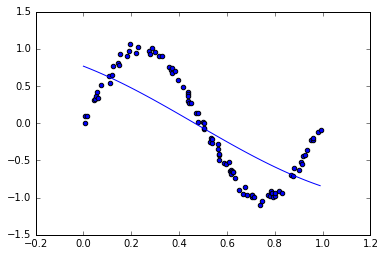

In [4]:
print('unoptimized ll')
lmc = LMC(xss, yss, kernels=[RBF()], normalize=False)
#lmc.rbf.variance = 1000
print(lmc)
print_diagram()

In [5]:
import scipy.optimize as sciopt
class DerivFree(Optimizer):
    def __init__(self):
        super().__init__()

    def opt(self, x_init, f_fp=None, f=None, fp=None):
        options = {'iprint': 1, 'disp': True, 'maxiter': 100}
        res = sciopt.minimize(
            f,
            x_init,
            method='COBYLA',
            options=options)
        print(res.message)
        self.x_opt = res.x
    
lmc.optimize(optimizer=DerivFree())

Optimization terminated successfully.



Name : lmc
Objective : -174.8764351154212
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  lmc.                 |              value  |  constraints  |  priors
  rbf.variance         |      1.86731870046  |      +ve      |        
  rbf.inv_lengthscale  |      8.14940570361  |      +ve      |        
  noise                |  0.000150075600672  |      +ve      |        


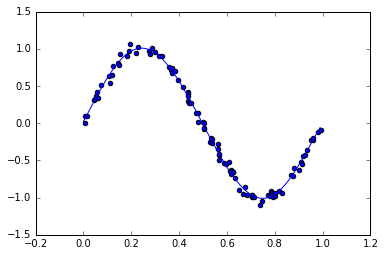

In [6]:
print(lmc)
print_diagram()


Name : GP regression
Objective : 105.59201232906497
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


 /usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


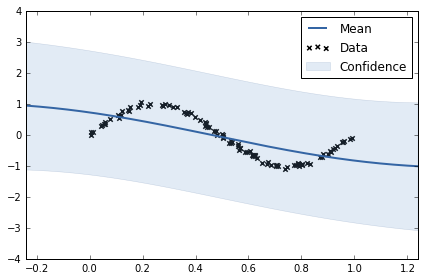

In [7]:
import GPy
kernel = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=1.)
m = GPy.models.GPRegression(np.array(xss).T,np.array(yss).T,kernel)
m.plot()
print(m)

In [8]:
m.optimize()

 /usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


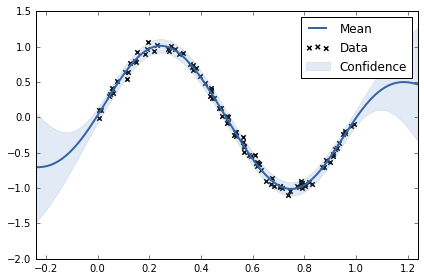

In [9]:
m.plot()

In [10]:
print(m)


Name : GP regression
Objective : -141.30973190970076
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |             value  |  constraints  |  priors
  rbf.variance             |    0.687855407237  |      +ve      |        
  rbf.lengthscale          |    0.254562115009  |      +ve      |        
  Gaussian_noise.variance  |  0.00217515318256  |      +ve      |        
